In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize=(9, 3)
else:
    figsize=(14, 4)

from util import util
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score


2023-11-21 08:15:36.374891: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 08:15:36.616304: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 08:15:36.616332: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 08:15:36.618140: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 08:15:36.772632: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 08:15:36.774376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Click-Through Rate Prediction

## Click-Through Rate Prediction

**Let's consider an automatic recommendation problem**

* Given a set of restaurant indexed on a a web platform (think Tripadvisor)
* ...We want to estimate how likely a user is to actually open the restaurant card

This is know as _click-through rate_

<center><img src="assets/la-montanara.jpg" width=45%/></center>

This example (and the approach) is based on this [TensorFlow Lattice Tutorail](https://www.tensorflow.org/lattice/tutorials/shape_constraints)

## Loading the Data

**Let's start by loading the dataset**

In [2]:
tr, val, ts = util.load_restaurant_data()
tr.iloc[:3]

,avg_rating,num_reviews,dollar_rating,clicked
0,3.927976,122.0,DDDD,1
1,3.927976,122.0,DDDD,0
2,3.927976,122.0,DDDD,0


* There are two numeric attributes, a categorical one, and a target
* Each row represents _one visualization event_, hence there might be _duplicates_

In [3]:
dt_in = ['avg_rating', 'num_reviews', 'dollar_rating']
ndup = np.sum(tr.duplicated(dt_in))
print(f'#examples: {len(tr)}, #duplicated inputs {ndup}')

#examples: 835, #duplicated inputs 395


* The click rate can be inferred by number of clicks for each restaurant

## Target Function

**This is a synthetic dataset, for which we know the target function**

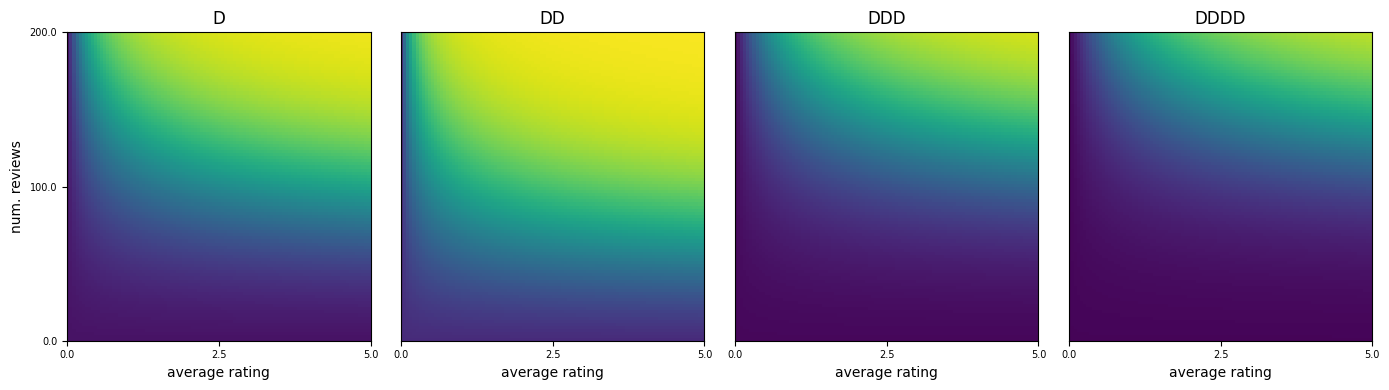

In [4]:
util.plot_ctr_truth(figsize=figsize)

* The click rate grows with the average rating and the number of reviews
* Average priced restaurant are clicked the most

## Data Distribution

**Let's check the attribute distribution _on the training set_**

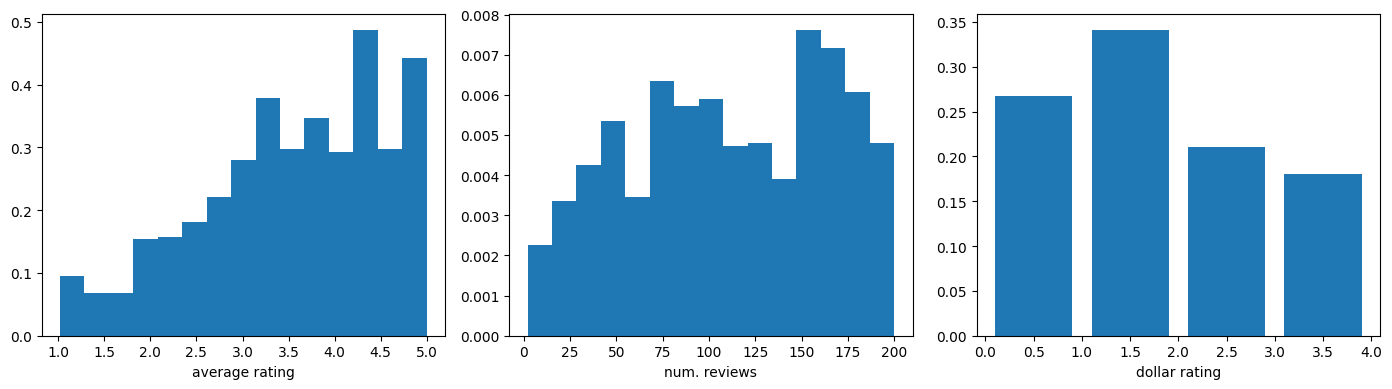

In [5]:
util.plot_ctr_distribution(tr, figsize=figsize)

## Data Distribution

**...Then _on the validation set_**

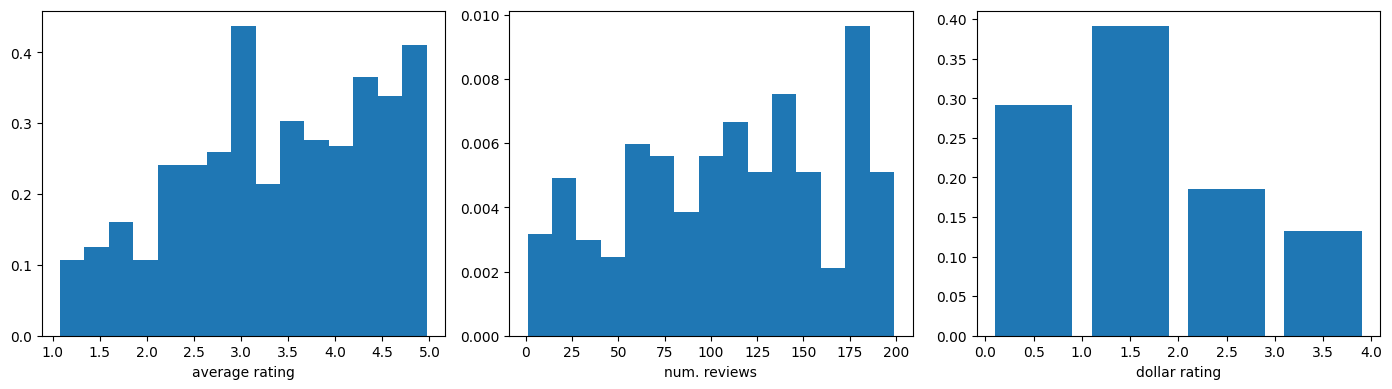

In [6]:
util.plot_ctr_distribution(val, figsize=figsize)

Not exactly the same, but it roughly matches

## Data Distribution

**...And finally _on the test set_**

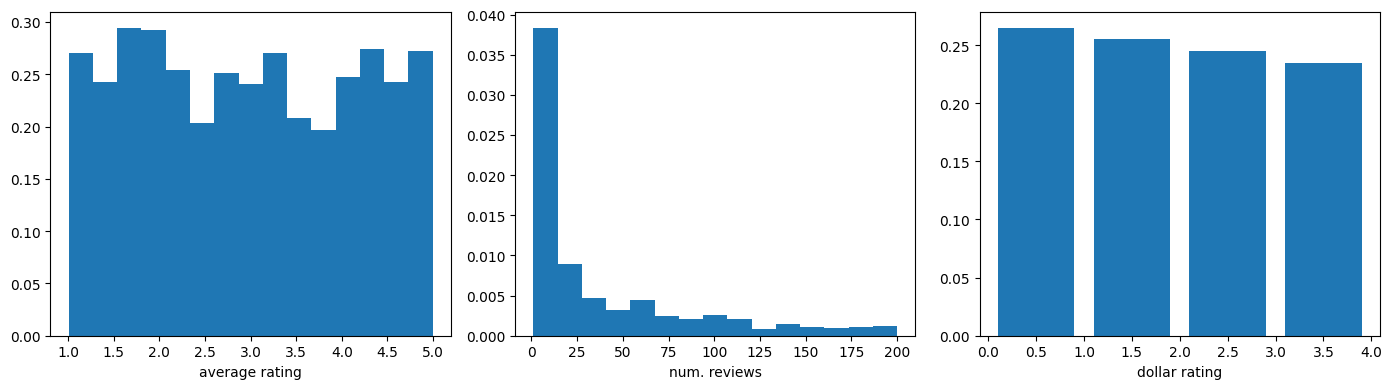

In [7]:
util.plot_ctr_distribution(ts, figsize=figsize)

Here there is _a strong discrepancy w.r.t. the training set_

## Distribution Discrepancy

**What is the reason for the discrepancy?**

A training set for this kind of problem will come from app usage data

* Users _seldom scroll through all_ search results
* ...So their clicks will be biased toward _high ranked restaurant_

Any training set obtained in this fashion will be _strongly biased_

**However, click rate prediction is typically use for ranking search results**

...Meaning that we will need to evaluate _also less viewed restaurants_

* In a practical problem, the test set _would not even be available_
* We have it just as a mean for validating our results

A bias in the training can be problematic: we will try to see that in action

<div class=big>How would you deal with this problem?</div>

<center>
Using sample weights (or data augmentation) might be a solution<br>
...But here we will focus on a different angle</center>

# A Baseline Approach

## Preparing the Data

**We will start by tackling the problem using a Multi Layer Perceptron**

We normalize the numeric data:

In [8]:
nf = ['avg_rating', 'num_reviews']
scale = tr[nf].max()

tr_s = tr.copy()
tr_s[nf] = tr_s[nf] / scale
val_s = val.copy()
val_s[nf] = val_s[nf] / scale
ts_s = ts.copy()
ts_s[nf] = ts_s[nf] / scale

We also adopt a one-hot encoding for the categorical data:

In [9]:
tr_sc = pd.get_dummies(tr_s).astype(np.float32)
val_sc = pd.get_dummies(val_s).astype(np.float32)
ts_sc = pd.get_dummies(ts_s).astype(np.float32)
dt_in_c = [c for c in tr_sc.columns if c != 'clicked']

## Preparing the Data

**Here is the result of our preparation**

In [10]:
tr_sc

,avg_rating,num_reviews,clicked,dollar_rating_D,dollar_rating_DD,dollar_rating_DDD,dollar_rating_DDDD
0,0.785773,0.610,1.0,0.0,0.0,0.0,1.0
1,0.785773,0.610,0.0,0.0,0.0,0.0,1.0
2,0.785773,0.610,0.0,0.0,0.0,0.0,1.0
3,0.866150,0.610,1.0,0.0,0.0,0.0,1.0
4,0.619945,0.590,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
830,0.597304,0.055,1.0,0.0,1.0,0.0,0.0
831,0.783784,0.505,1.0,1.0,0.0,0.0,0.0
832,0.783784,0.505,1.0,1.0,0.0,0.0,0.0
833,0.688336,0.270,1.0,0.0,1.0,0.0,0.0


## Building a Baseline Model

**Let's start by _ignoring the issue_**

...And building as baseline model an MLP _classifier_

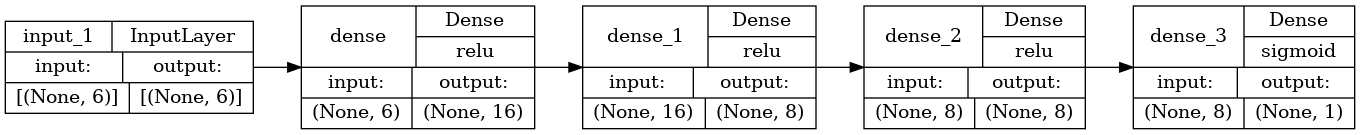

In [11]:
nn = util.build_nn_model(input_shape=len(dt_in_c), output_shape=1, hidden=[16, 8, 8], output_activation='sigmoid')
util.plot_nn_model(nn)

* Remember this is a stochastic prediction problem
* So, even if we train a classifier _we are not interested in classes_
* Rather, we care about _estimated probabilities_

## Training the Baseline Model

**We can train the model as usual**

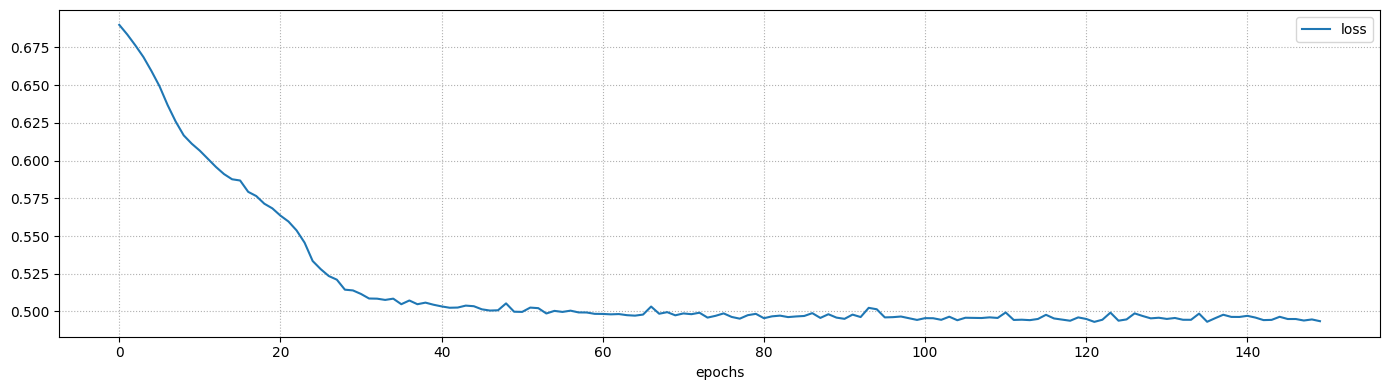

Final loss: 0.4935 (training)


In [12]:
nn = util.build_nn_model(input_shape=len(dt_in_c), output_shape=1, hidden=[16, 8, 8], output_activation='sigmoid')
history = util.train_nn_model(nn, tr_sc[dt_in_c], tr_sc['clicked'], loss='binary_crossentropy', batch_size=32, epochs=150)
util.plot_training_history(history, figsize=figsize)

* It seems we are reasonably close to convergence

## Evaluating the Predictions

**This is not a classification problem, so _accuracy is not a good metric_**

* The output of our system is _meant to be interpreted as a probability_
* ...So, rounding to obtain a deterministic prediction may be too restrictive

**Instead, we will make a first evaluation using a _ROC curve_**

A Receiver Operating Characteristic curve is a type of plot

* We consider multiple threshold values
  - Each threshold is meant to be used for discriminating between classes
  - The usual rounding approach is equivalent to a 0.5 threshold
* On the $x$ axis, we report the false positive rate for each threshold
* On the $y$ axis, we report the true positive rate for each threshold

## Evaluating the Predictions

**A ROC curve looks like this** (image from wikipedia)

<center><img src="assets/Roccurves.png" width=40%/></center>

* The large the Area Under Curve (AUC), the better the performance
* The AUC value is guaranteed to be in the $[0, 1]$ interval

## Evaluating the Predictions

**Let's compute the AUC values for all sets**

In [13]:
pred_tr = nn.predict(tr_sc[dt_in_c], verbose=0)
pred_val = nn.predict(val_sc[dt_in_c], verbose=0)
pred_ts = nn.predict(ts_sc[dt_in_c], verbose=0)
auc_tr = roc_auc_score(tr_sc['clicked'], pred_tr)
auc_val = roc_auc_score(val_sc['clicked'], pred_val)
auc_ts = roc_auc_score(ts_sc['clicked'], pred_ts)
print(f'AUC score: {auc_tr:.2f} (training), {auc_val:.2f} (validation), {auc_ts:.2f} (test)')

AUC score: 0.81 (training), 0.80 (validation), 0.77 (test)


* The model works well on the training distribution
* But less well on the testing data (as expected)

## Issues with the MLP

**Here we have again _the ground truth_ for our click rate**

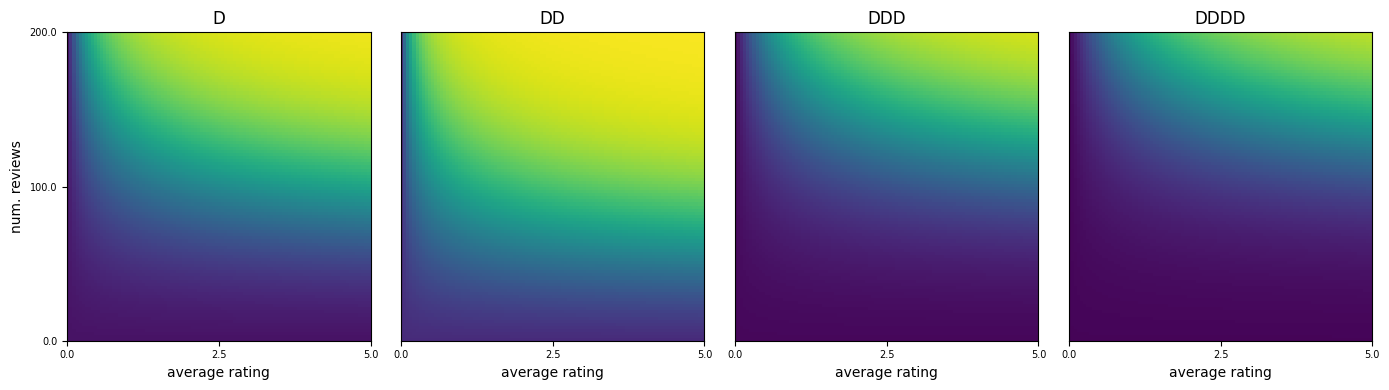

In [14]:
util.plot_ctr_truth(figsize=figsize)

## Issues with the MLP

**...And here is the full (prediction) _output space for the MLP_**

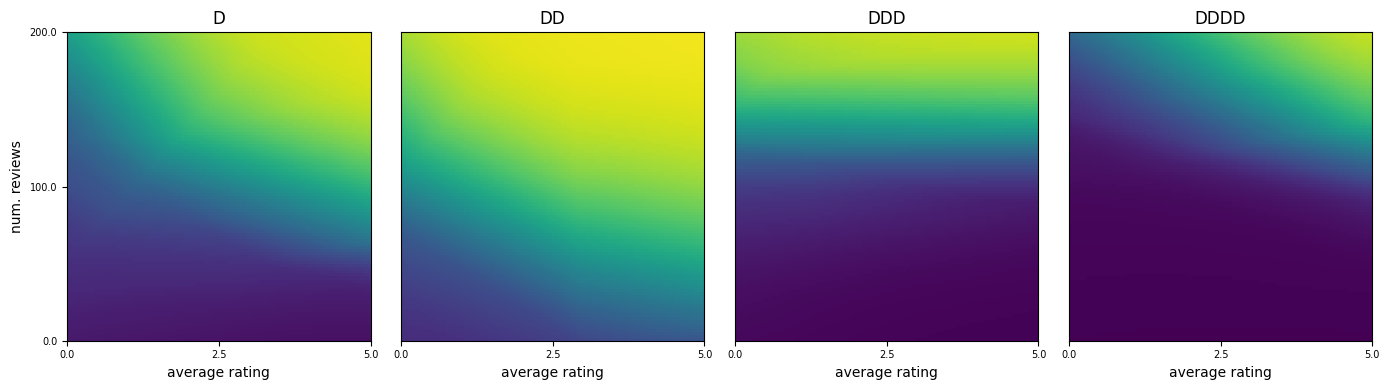

In [15]:
util.plot_ctr_estimation(nn, scale, figsize=figsize)

> **Something odd is happening here: can you tell what?**

## Constraint Violations

**In some areas, increasing an attribute has _the opposite of the expected effect_**

Our problem has natural _monotonicities_, which are _may not hold_ for the MLP

* The motivation is that poor data for some region of the input space
* ...And ML models often have poor out-of-distribution behavior 

**This is a significant issue in practice**

Having a statistically representative training set is _a luxury_

* E.g. time series, organ trasplants programs, promo sales...
* If we give up on those problem, we loose a lot of potential

**Sample weights cannot fix this issue**

* In fact, _most ML models_ are _naturally incapable_ of enforcing constraints
* ..But most is not all, so let's see some exceptions :-)